In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
CELL_W_SIZE = 64
ncells = CELL_W_SIZE * CELL_W_SIZE

dirs = np.array([[0.0, np.pi/2.0],
                         [np.pi, 3*np.pi/2.0]])
dirs = np.tile(dirs, (CELL_W_SIZE//2, CELL_W_SIZE//2))
dirs = np.reshape(dirs.T, (-1))

dir_vects = np.vstack([np.cos(dirs), np.sin(dirs)])

x = np.arange(0, CELL_W_SIZE) - (CELL_W_SIZE-1) / 2.0

X,Y = np.meshgrid(x,x)

x = np.vstack([np.reshape(X.T, (-1)), np.reshape(Y.T, (-1))])
# (2, 16)

# Sets length of field shift in recurrent connections
cell_spacing = Y[1,0] - Y[0,0]

# Offset of center of inhibitory output
ell = 2 * cell_spacing

# Distance from (0,0) for A below
cell_dists = np.linalg.norm(x.T, 2, axis=1)
# (16,)

a = 1                          # if >1, uses local excitatory connections
lambda_ = 13                   # approx the periodicity of the pattern
beta = 3 / (lambda_ * lambda_) # width of the excitatory region
gamma = 1.1 * beta             # how much inhibitory region wider than excitatory 
#sparse_threshold = -1e-6 #

W = []

for i in range(ncells):
    tmp = np.tile(np.reshape(x[:,i], (2,1)), (1, ncells))
    # (2,16)
    shifts = tmp - x - ell * dir_vects
    # (2,16)

    # TODO: 無駄が多い?
    squared_shift_lengths = np.linalg.norm(shifts.T, 2, axis=1) ** 2
    # (16,)
    
    tmp = a * np.exp(-gamma * squared_shift_lengths) - np.exp(-beta * squared_shift_lengths)
    # (16,)
    W.append(tmp)


W = np.vstack(W)

R  = np.sqrt(ncells)/2   # radius of main network, in cell-position units
a0 = np.sqrt(ncells)/32  # envelope fall-off rate
dr = np.sqrt(ncells)/2   # radius of tapered region, in cell-position units

A = (((cell_dists) - R + dr) / dr)
A = np.exp(-a0 * A * A)

#non_tapered_inds = find(cellDists < (R-dr));
#A(nonTaperedInds) = 1

dt = 0.5 # time step, ms
tau = 10.0

s = np.random.uniform(low=0.0, high=1.0, size=[ncells])
# (16,)

for i in range(1000):
    # Feedforward input
    #B = A .* (1 + alpha * dirVects' * v)'
    B = A
    # (16,)
    
    # Total synaptic driving currents
    s_inputs = np.dot(W, s.T).T + B
    
    # Synaptic drive only increases if input cells are over threshold 0
    s_inputs = np.maximum(s_inputs, 0.0)
    
    # Synaptic drive decreases with time constant tau
    s = s + dt * (s_inputs - s) / tau

In [22]:
s = np.reshape(s, [CELL_W_SIZE, CELL_W_SIZE])

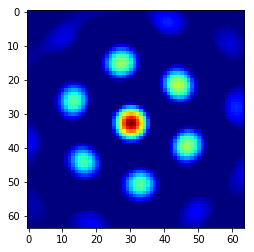

In [23]:
plt.imshow(s,  cmap="jet")